# Region Definition
In this notebook, each station is assigned to one of Turkey's seven regions, i.e., Mediterranean Sea, Aegean Sea, Marmara, Black Sea, Central Anatolia, Eastern Anatolia, and Southeastern Anatolia.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import os
from pathlib import Path
import folium

In [2]:
# Changing path to the main directory path
os.chdir(Path.cwd().parents[0])

In [3]:
# Loading station definitions file
st_df = pd.read_csv('cleaned_data/station_definitions.csv')

# Slicing the stations remaining in the processed data
et_df = pd.read_csv('processed_data/et_data.csv')
available_stations = et_df['st_num'].unique()
cond = st_df['st_num'].isin(available_stations)
st_df = st_df.loc[cond].reset_index(drop=True)

# Converting to Geopandas Dataframe
st_df = gpd.GeoDataFrame(st_df, geometry=gpd.points_from_xy(st_df['longitude'], st_df['latitude']), crs='EPSG:4326')
st_df = st_df.drop(columns=['latitude', 'longitude'])


# Loading Turkish regions shapefile
path = 'processed_data/map_data/tr_regions_mod.geojson'
tr_regions = gpd.read_file(path)

# Adding colors
region_colors = {
    'Mediterranean': '#E66E37',
    'Central Anatolia': '#E6E345',
    'Marmara': '#AF77E6',
    'Black Sea': '#7CE678',
    'Southeastern Anatolia': '#E6A182',
    'Eastern Anatolia': '#E4E67E',
    'Aegean': '#6CE6D9'}
tr_regions['color'] = tr_regions['region'].replace(region_colors)


# Adding region names to stations
st_regions = gpd.sjoin(tr_regions, st_df)[['st_num', 'region', 'color']]
st_df = st_df.merge(st_regions, on='st_num', how='left')

# Filling the values in stations with unknown regions
st_df['region'] = st_df['region'].fillna('Unknown')
st_df['color'] = st_df['color'].fillna('#000000')

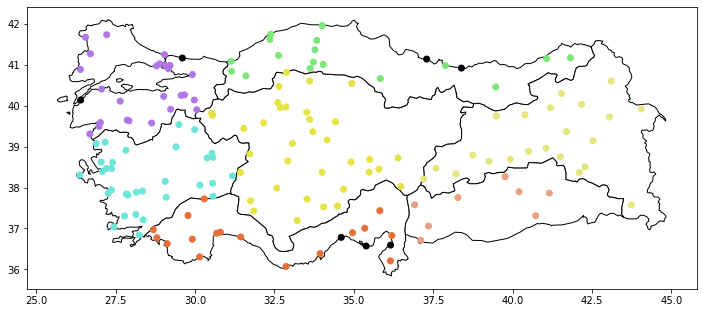

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

base = tr_regions.plot(ax=ax, color='white', edgecolor='black')
st_df.plot(ax=base, color=st_df['color'])
plt.show()

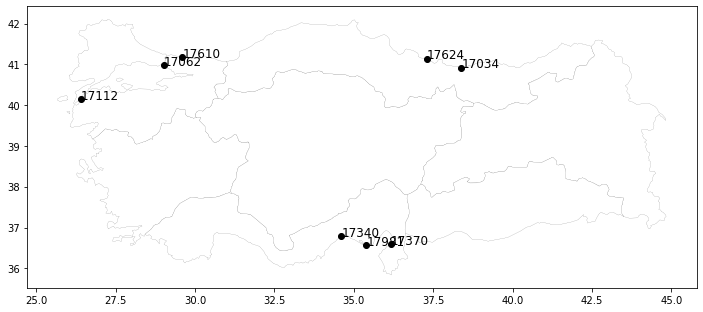

In [5]:
# Plotting the stations with unknown regions
fig, ax = plt.subplots(figsize=(12, 6))
tr_regions.plot(ax=ax, color='white', edgecolor='black', lw=0.1)

cond = st_df['region'] == 'Unknown'
unknown_stations = st_df.loc[cond]
unknown_stations.plot(ax=ax, color='black')

for row in unknown_stations.iterrows():
    row = row[1]
    ax.text(s=f"{row['st_num']}", x=row['geometry'].x, y=row['geometry'].y, fontsize=12)

In [6]:
unknown_stations

,st_num,province,elevation,geometry,region,color
3,17034,Giresun,38.0,POINT (38.38780 40.92270),Unknown,#000000
8,17062,İstanbul,5.0,POINT (29.01900 40.98830),Unknown,#000000
25,17112,Çanakkale,6.0,POINT (26.39930 40.14100),Unknown,#000000
80,17340,Mersin,7.0,POINT (34.60310 36.78080),Unknown,#000000
82,17370,Hatay,4.0,POINT (36.15820 36.59240),Unknown,#000000
88,17610,İstanbul,83.0,POINT (29.60070 41.16880),Unknown,#000000
91,17624,Ordu,16.0,POINT (37.29300 41.14300),Unknown,#000000
153,17981,Adana,22.0,POINT (35.38940 36.56830),Unknown,#000000


In [7]:
# Assigining these stations to their corresponding regions
cond = st_df['st_num'].isin([17034, 17624])
st_df.loc[cond, 'region'] = 'Black Sea'

cond = st_df['st_num'].isin([17340, 17370, 17981])
st_df.loc[cond, 'region'] = 'Mediterranean'

cond = st_df['st_num'].isin([17112, 17062, 17610])
st_df.loc[cond, 'region'] = 'Marmara'

# Updating colors
st_df['color'] = st_df['region'].replace(region_colors)

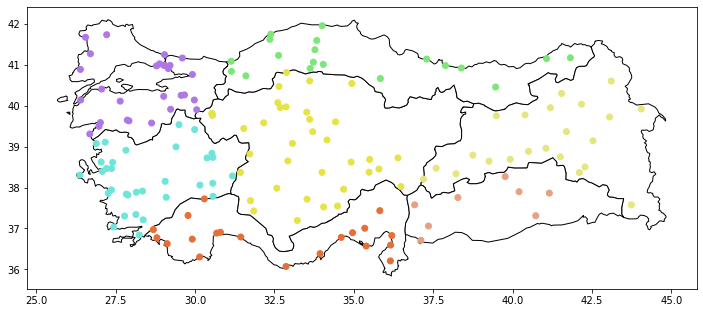

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

base = tr_regions.plot(ax=ax, color='white', edgecolor='black')
st_df.plot(ax=base, color=st_df['color'])
plt.show()

Viewing the stations on a map with a terrain-background using Folium

In [9]:
def plot_map(st_data, region_data, color=None, location=[39, 35.5], zoom=6):
    '''
    Plot stations in data with pop-ups for st_num.
    If color == None, a column named 'color' is expected to contain the color of each station.
    Else, all stations will have the same color defined in color parameter.
    '''
    tiles = 'https://stamen-tiles-{s}.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}{r}.png'
    attr = 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0"\
            >CC BY 3.0</a> &mdash; Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> \
            contributors'
    
    # Creating Folium map
    m = folium.Map(location = location, zoom_start = zoom, tiles = tiles, attr = attr)
    
    # Plotting region polygons
    df = region_data.copy()
    
    for _, row in df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': 'black', 'color': 'black'})
        popup_txt = '<h5><b>Region:</b> {}</h5>\n'.format(row['region'])
        folium.Popup(popup_txt, min_width = 100, max_width = 200).add_to(geo_j)
        geo_j.add_to(m)

    
    
    # Radius of station indicator
    radius = 3.5
    
    df = st_data.copy()
    
    df['loc'] = df['geometry'].apply(lambda point: (point.y, point.x))
    
    
    if color is not None:
        df['color'] = color
        
    for _, row in df.iterrows():
        txt = '<h5><b>Province:</b> {}</h5>\n'.format(row['province'])
        txt += '<h5><b>Region:</b> {}</h5>'.format(row['region'])
        txt += '<h5><b>Station:</b> {}</h5>'.format(row['st_num'])
        popup = folium.Popup(txt, min_width = 100, max_width = 200)
        
        loc = row['loc']

        folium.CircleMarker(location = loc,
                            color = row['color'],
                           radius = radius
                           ).add_child(popup).add_to(m)
        
    display(m)

In [10]:
test = plot_map(st_df, tr_regions)

In [11]:
# Modifying the region definition of some stations on the borders between region
cond = st_df['st_num'] == 17238
st_df.loc[cond, 'region'] = 'Aegean'

cond = st_df['st_num'] == 17646
st_df.loc[cond, 'region'] = 'Black Sea'

# Updating colors
st_df['color'] = st_df['region'].replace(region_colors)

Plotting the number of data points and stations per region

In [12]:
def get_region_data_count(region_name, et_data):
    """
    Gets the number of data points in the defined region name.
    """
    
    cond = et_data['region'] == region_name
    data_count = et_data.loc[cond].shape[0]
    
    return data_count

def plot_region_details(st_data, et_data, figsize = (18, 4)):
    '''
    Plot cluster details, i.e., number of stations and datapoints per cluster.
    
    '''
    colors = ['skyblue', 'limegreen']
    linewidth = 4
    
    
    fig, axs = plt.subplots(1, 2, figsize = figsize, constrained_layout = True)
    fig.suptitle('Region Details', fontsize = 14)
    
    st_df = st_data.copy()
    et_df = et_data.copy()
    
    # Adding region names to ET data
    et_df = et_df.merge(st_df[['st_num', 'region']], on='st_num')
    
    # Computing station count
    region_data = st_df.groupby('region')[['st_num']].count().reset_index().rename(columns={'st_num': 'station_count'})
    # Computing data count
    region_data['data_count'] = region_data['region'].apply(get_region_data_count, et_data=et_df)
    
    
    # Plotting
    colors = ['skyblue', 'limegreen']
    for i, variable in enumerate(['data_count', 'station_count']):
        region_data = region_data.sort_values(by=variable)
        ax = axs[i]
        ax.barh(y='region', width=variable, data=region_data, color=colors[i])
        ax.set_xlabel(variable.replace('_', ' ').title())
    
    return ax
    

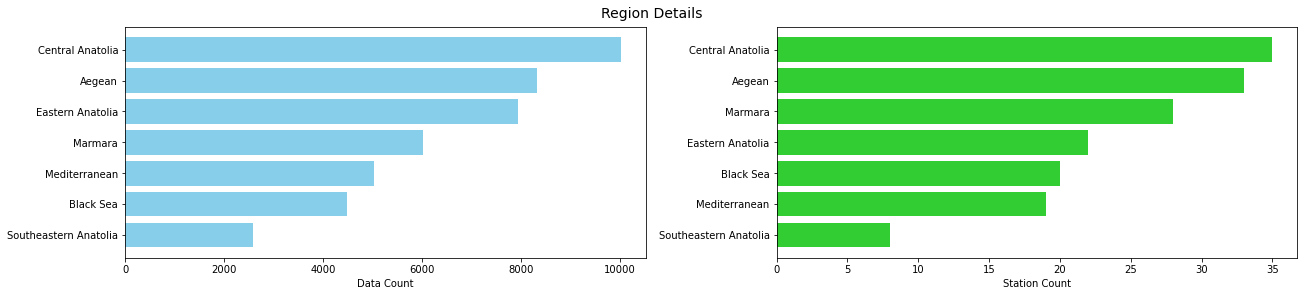

In [13]:
ax = plot_region_details(st_df, et_df)

Saving the station definitions dataframe to processed_data directory

In [14]:
st_df['longitude'] = st_df['geometry'].apply(lambda point: point.x)
st_df['latitude'] = st_df['geometry'].apply(lambda point: point.y)
st_df = st_df.drop(columns=['color', 'geometry'])

st_df = st_df[['st_num', 'province', 'region', 'elevation', 'longitude', 'latitude']]

In [15]:
# st_df.to_csv('processed_data/station_definitions.csv', index=False)